In [7]:
from forwarder import *

from matplotlib import pyplot as plt
from sklearn import linear_model as lm
from scipy import stats
from scipy.interpolate import interp1d, pchip

# Run simulation experiment

In [3]:
model_time = 4
launches = 1000
disp_num = range(1, 8)
req_itv = [i * 0.1 for i in range(2, 10)]
tariff = [4 + i * 0.5 for i in range(9)]

risks = []

# set freight forwarder
ff = FreightForwarder()
ff.costs_1h = 2.5
ff.costs_1h_paid = 2

# run experiment
for t in tariff:
    # set tariff
    ff.tariff = t
    mtx = []
    for dn in disp_num:
        row = []
        # set dispatchers
        ff.dispatchers = [Dispatcher(name=f'D#{i+1}') for i in range(dn)]
        for itv in req_itv:
            # set requests flow
            rf = RequestsFlow(s_itv=Stochastic(law='expon', scale=itv),
                            model_time=model_time)
            positive = 0
            for launch in range(launches):
                # generate demand
                rf.generate()
                # simulate servicing and calculate profit
                ff.reset()
                positive += ff.serve(rf)['profit'] <= 0
            row.append(positive/launches)
        mtx.append(row)
    risks.append(mtx)

# Visualize experiment results

In [103]:
def plot_2D(risks, interpolate=False, fontsize=10):
    risks = np.array(risks)
    
    plt.figure(dpi=120)
    for col in range(risks.shape[1]):
        x, y = disp_num, risks[:, col]
        label = f'{req_itv[col]:.1f} hours'
        if interpolate:
            x_smooth = np.linspace(x[0], x[-1], 100)
            f = interp1d(x, y, kind='cubic')
            plt.plot(x_smooth, f(x_smooth), label=label)
        else:
            plt.plot(x, y, label=label)
        
    plt.xlabel('Dispatchers\' number', fontsize=fontsize)
    plt.ylabel('Risk of entering the market', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.title('a', fontsize=fontsize, loc='left', x=-0.1, y=-0.15, pad=0)
    plt.show()
    
    plt.figure(dpi=120)
    for row in range(risks.shape[0]):
        x, y = req_itv, risks[row, :]
        label = f'#dispatchers={disp_num[row]}'
        if interpolate:
            x_smooth = np.linspace(x[0], x[-1], 100)
            f = interp1d(x, y, kind='cubic')
            plt.plot(x_smooth, f(x_smooth), label=label)
        else:
            plt.plot(x, y, label=label)
    plt.xlabel('Requests\' interval [hours]', fontsize=fontsize)
    plt.ylabel('Risk of entering the market', fontsize=fontsize)
    plt.legend(fontsize=fontsize)
    plt.title('b', fontsize=fontsize, loc='left', x=-0.1, y=-0.15, pad=0)
    plt.show()

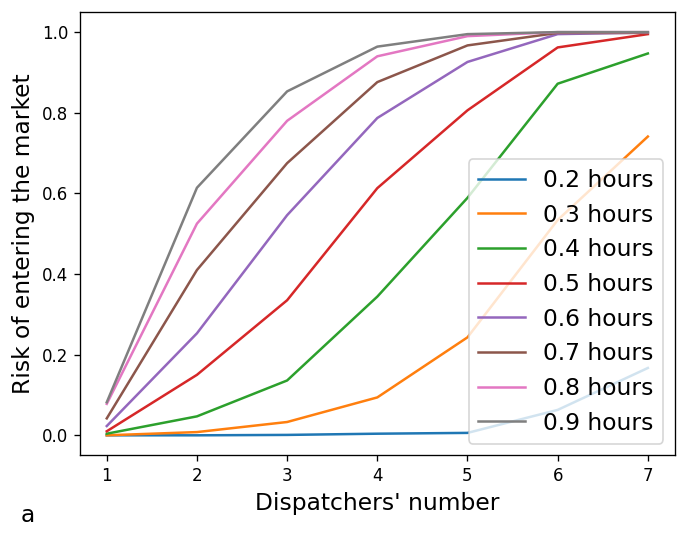

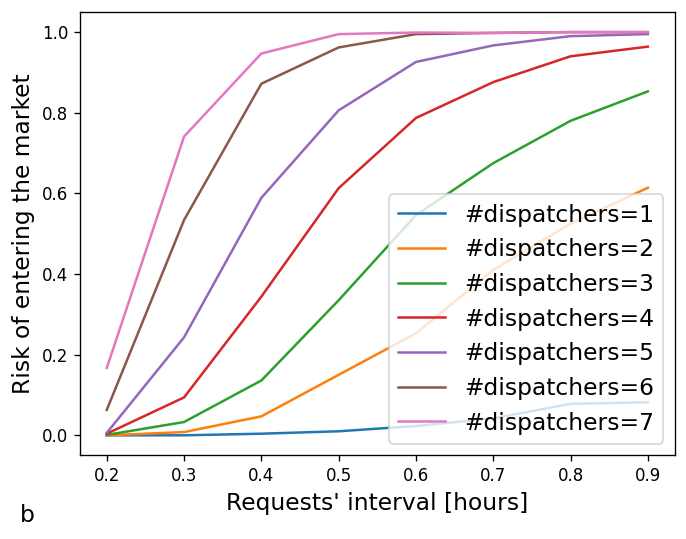

In [107]:
plot_2D(risks[3], fontsize=14)

In [100]:
def plot_3D(Y, X, axes=(0, 1), place=0, ttl=None, zoom=1):
    
    ylabel = list(Y.keys())[0]
    ys = np.array(list(Y.values())[0])
    xlabels = list(X.keys())
    xs = np.array(list(X.values()), dtype=object)

    gdata = []
    for i in range(ys.shape[axes[0]]):
        for j in range(ys.shape[axes[1]]):
            if axes == (0, 1):
                value = ys[i][j][place]
            elif axes == (1, 0):
                value = ys[j][i][place]
            elif axes == (1, 2):
                value = ys[place][i][j]
            elif axes == (2, 1):
                value = ys[place][j][i]
            elif axes == (0, 2):
                value = ys[i][place][j]
            elif axes == (2, 0):
                value = ys[j][place][i]
            else:
                value = None
            gdata.append([xs[axes[0]][i], xs[axes[1]][j], value])
            
    gdata = np.array(gdata)
    
    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(projection='3d')
    ax.set_xlabel(xlabels[axes[0]])
    ax.set_ylabel(xlabels[axes[1]])
    ax.set_zlabel(ylabel)
    shape = (ys.shape[axes[0]], ys.shape[axes[1]])
    ax.plot_surface(np.reshape(gdata[:, 0], shape),
                    np.reshape(gdata[:, 1], shape),
                    np.reshape(gdata[:, 2], shape),
                    alpha=0.8)
    if ttl:
        ax.set_title(ttl, fontsize=12, loc='left', x=0, y=0, pad=0)
        ax.set_box_aspect(aspect=None, zoom=zoom)
    plt.show()

In [101]:
print(np.array(risks).shape)
Y = {'Estimated risk': risks}
X = {'Forwarder\'s tariff [$/request]': tariff,
     'Dispatchers\' number': disp_num,
     'Requests\' interval [hours]': req_itv}

(9, 7, 8)


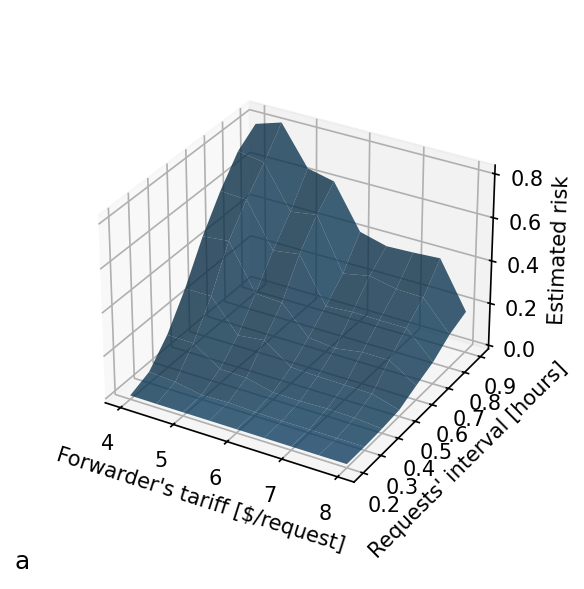

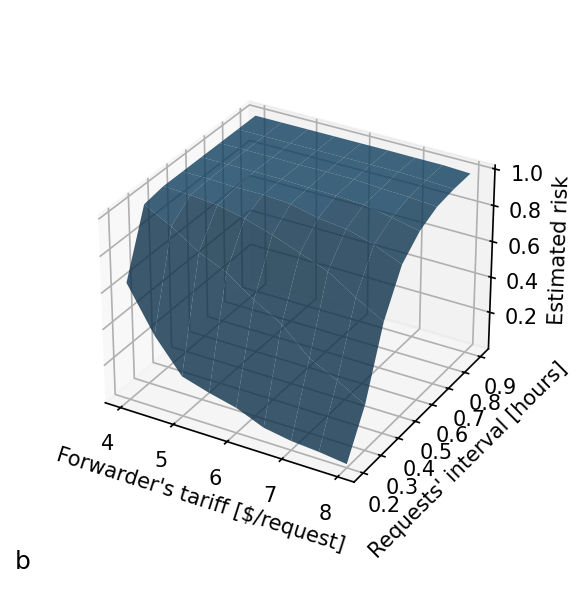

In [102]:
zoom = .8
plot_3D(Y, X, axes=(0, 2), place=1, ttl='a', zoom=zoom)
plot_3D(Y, X, axes=(0, 2), place=6, ttl='b', zoom=zoom)

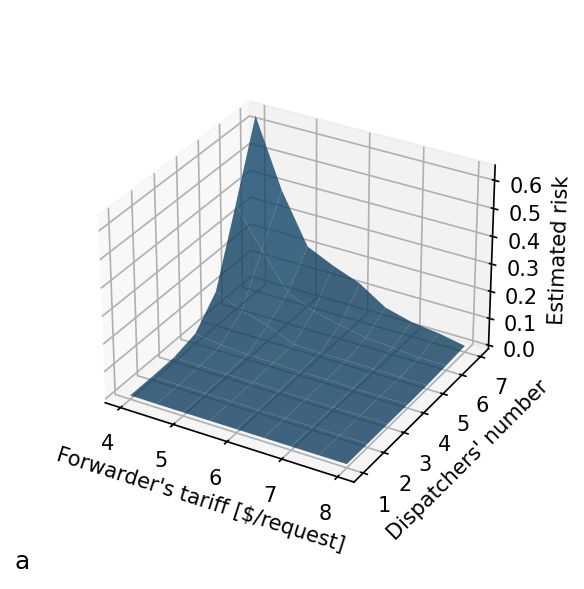

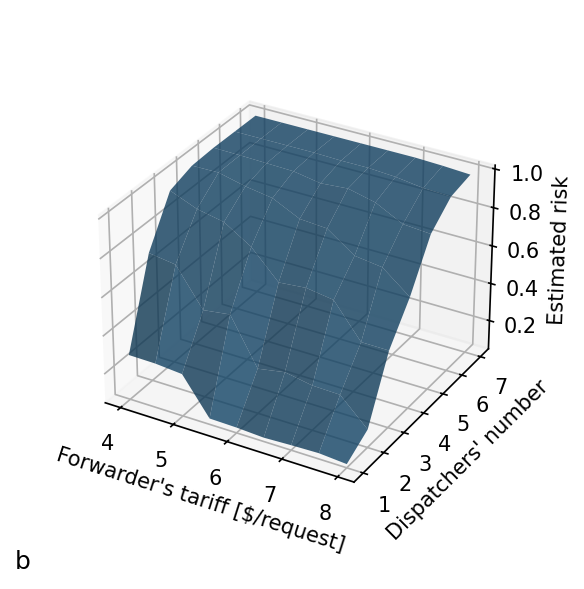

In [96]:
plot_3D(Y, X, axes=(0, 1), place=0, ttl='a', zoom=zoom)
plot_3D(Y, X, axes=(0, 1), place=6, ttl='b', zoom=zoom)

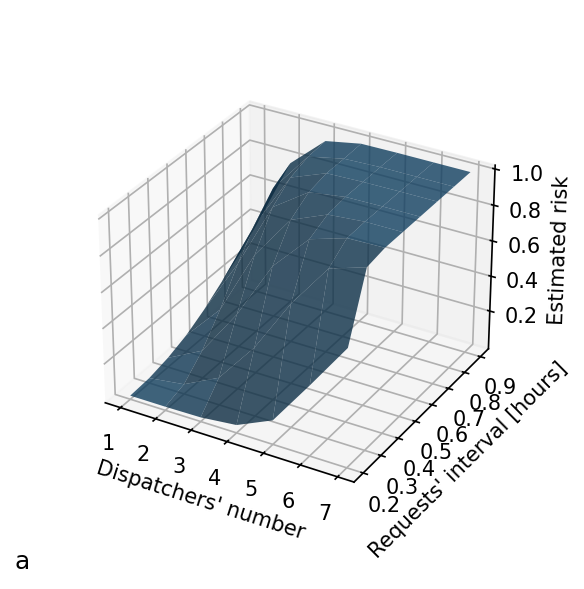

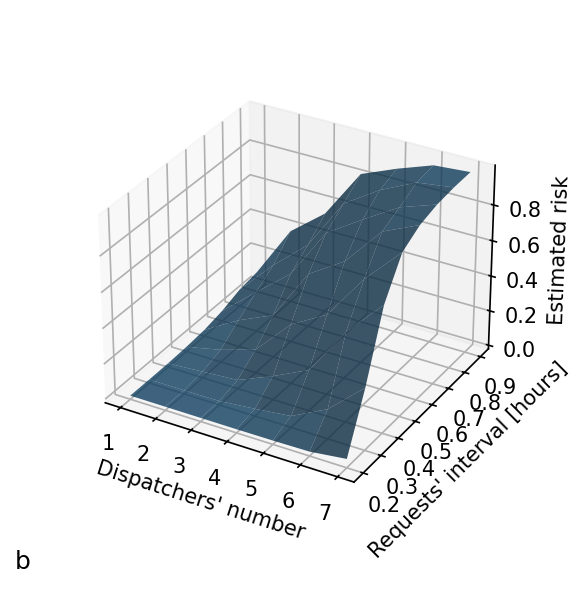

In [79]:
plot_3D(Y, X, axes=(1, 2), place=0, ttl='a', zoom=zoom)
plot_3D(Y, X, axes=(1, 2), place=7, ttl='b', zoom=zoom)

# Regression analysis

In [108]:
def make_regression(X, Y, intercept=True, alpha=0.05, verbose=False):
    '''
    Performs the regression analysis:
    * calculates coefficients for multiple linear regression
    * estimates the coefficient of determination
    * provides confidence intervals for the given alpha
    Arguments:
    X - explanatory variables
    Y - an explained variable
    alpha - significance level
    Returns the fitted model, the determination coefficient, and confidence intervals
    '''
    rmodel = lm.LinearRegression(fit_intercept=intercept)
    # estimate regression coefficients
    rmodel.fit(X, Y)
    if verbose:
        print(f'intercept={rmodel.intercept_:.6f}')
        print(f'coefs={rmodel.coef_}')
    # get the model predictions
    mY = rmodel.predict(X)
    # calculate residuals
    errors = mY - Y
    # calculate empirical average of the explained variable
    avgY = Y.mean()
    # estimate the coefficient of determination
    r2 = 1 - sum([e*e for e in errors]) / sum([(y - avgY)**2 for y in Y])
    if verbose: print(f'R2={r2:.6f}')
    # calculate the number of the degrees of freedom
    df = len(X) - len(rmodel.coef_) - 1
    s2 = sum([e*e for e in errors]) / df
    # get t-variable for the provided alpha and estimated df
    t_alpha = stats.t.ppf(1 - alpha / 2, df)
    if verbose: print(f't_alfa({alpha},{df})={t_alpha:.6f}')
    XTX = X.T.dot(X)
    invXTX = np.matrix(XTX).I
    # calculate confidence intervals
    bounds = {}
    for i in range(len(rmodel.coef_)):
        if invXTX[i, i] > 0:
            LB = rmodel.coef_[i] - t_alpha * np.sqrt(s2 * invXTX[i, i])
            UB = rmodel.coef_[i] + t_alpha * np.sqrt(s2 * invXTX[i, i])
            bounds[i] = (LB, UB)
            if verbose: print(f'coef{i + 1}\t{LB*UB > 0}\t{LB:.6f}\t{UB:.6f}')
    return rmodel, r2, bounds

#### Hypothesis #1: $$risk = b_0 + b_1 \cdot tariff + b_2 \cdot dispatchers + b_3 \cdot interval$$

In [109]:
X1 = np.array([[t, d, i] for t in tariff for d in disp_num for i in req_itv])
# X1 = np.array([[d, i] for d in disp_num for i in req_itv])
Y1 = np.array(risks).flatten()
# Y1 = np.array(risks[5]).flatten()
make_regression(X1, Y1, intercept=True, verbose=True)

intercept=-0.127267
coefs=[-0.07760774  0.13097024  1.0160941 ]
R2=0.838252
t_alfa(0.05,500)=1.964720
coef1	True	-0.083892	-0.071324
coef2	True	0.124385	0.137555
coef3	True	0.960429	1.071759


(LinearRegression(),
 0.8382517933127565,
 {0: (-0.08389178638116838, -0.07132368980930782),
  1: (0.12438521932000231, 0.13755525687047324),
  2: (0.9604293261426582, 1.071758882474123)})

In [110]:
make_regression(X1, Y1, intercept=False, verbose=True)

intercept=0.000000
coefs=[-0.09176514  0.12703763  0.9748953 ]
R2=0.835094
t_alfa(0.05,500)=1.964720
coef1	True	-0.098110	-0.085420
coef2	True	0.120389	0.133687
coef3	True	0.918690	1.031101


(LinearRegression(fit_intercept=False),
 0.8350939218640764,
 {0: (-0.09811023840650808, -0.08542004901746715),
  1: (0.1203886364612447, 0.13368661438659374),
  2: (0.9186897710507497, 1.0311008387383878)})

#### Hypothesis #3: $$risk = b_0 + b_1 \cdot \ln(tariff) + b_2 \cdot \ln(dispatchers) + b_3 \cdot \ln(interval)$$

In [111]:
X3 = np.array([[np.log(t), np.log(d), np.log(i)] for t, d, i in X1])
# X3 = np.array([[np.log(d), np.log(i)] for d, i in X1])
Y3 = np.copy(Y1)
make_regression(X3, Y3, intercept=True, verbose=True)

intercept=1.139286
coefs=[-0.45205414  0.40917411  0.49653164]
R2=0.850610
t_alfa(0.05,500)=1.964720
coef1	True	-0.471016	-0.433092
coef2	True	0.388420	0.429928
coef3	True	0.468939	0.524124


(LinearRegression(),
 0.8506095648356559,
 {0: (-0.4710162089897119, -0.4330920640045656),
  1: (0.38841987296747993, 0.42992834110575884),
  2: (0.4689389250477779, 0.5241243486633833)})

In [112]:
make_regression(X3, Y3, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.12973515 0.45852955 0.44738599]
R2=0.733508
t_alfa(0.05,500)=1.964720
coef1	True	0.104409	0.155061
coef2	True	0.430810	0.486249
coef3	True	0.410533	0.484239


(LinearRegression(fit_intercept=False),
 0.7335076745623076,
 {0: (0.10440913626982579, 0.15506115459577208),
  1: (0.4308099046032383, 0.4862491950511979),
  2: (0.41053278027505014, 0.484239203699957)})

#### Hypothesis #5: $$risk = b_0 \cdot {tariff}^{b_1} \cdot {dispatchers}^{b_2} \cdot {interval}^{b_3}$$

In [138]:
X5 = np.copy(X3)
Y5 = np.array([np.log(y+1e-6) for y in Y1])
model, _, _ = make_regression(X5, Y5, intercept=True, verbose=True)
print(np.exp(model.intercept_))

intercept=3.642595
coefs=[-3.38725993  2.78798478  4.72901538]
R2=0.691944
t_alfa(0.05,500)=1.964720
coef1	True	-3.632545	-3.141975
coef2	True	2.519517	3.056453
coef3	True	4.372088	5.085943
38.190803731221656


In [114]:
make_regression(X5, Y5, intercept=False, verbose=True)

intercept=0.000000
coefs=[-1.52712821  2.94578697  4.57188397]
R2=0.677191
t_alfa(0.05,500)=1.964720
coef1	True	-1.778218	-1.276039
coef2	True	2.670966	3.220608
coef3	True	4.206510	4.937258


(LinearRegression(fit_intercept=False),
 0.67719137857944,
 {0: (-1.7782179066810369, -1.2760385107059264),
  1: (2.6709660450348567, 3.220607901580264),
  2: (4.206510105552761, 4.937257831276559)})

#### Hypothesis #7: $$1-risk = b_0 \cdot {tariff}^{b_1} \cdot {dispatchers}^{b_2} \cdot {interval}^{b_3}$$

In [115]:
X7 = np.copy(X3)
Y7 = np.array([np.log(1 - y + 1e-6) for y in Y1])
make_regression(X7, Y7, intercept=True, verbose=True)

intercept=-10.449639
coefs=[ 5.3100757  -2.87601408 -3.26463646]
R2=0.523808
t_alfa(0.05,500)=1.964720
coef1	True	4.994757	5.625394
coef2	True	-3.221134	-2.530894
coef3	True	-3.723473	-2.805800


(LinearRegression(),
 0.5238075280619454,
 {0: (4.99475740437711, 5.625393990903585),
  1: (-3.221134041126219, -2.5308941248691825),
  2: (-3.7234727378283448, -2.8058001788664044)})

In [116]:
make_regression(X7, Y7, intercept=False, verbose=True)

intercept=0.000000
coefs=[-0.02614945 -3.32870677 -2.81386805]
R2=0.410245
t_alfa(0.05,500)=1.964720
coef1	False	-0.377058	0.324759
coef2	True	-3.712780	-2.944633
coef3	True	-3.324493	-2.303243


(LinearRegression(fit_intercept=False),
 0.4102453359148662,
 {0: (-0.3770577134293732, 0.32475881530337525),
  1: (-3.712780415523476, -2.944633130113862),
  2: (-3.324493178060183, -2.303242930922911)})

#### Hypothesis #9: $$risk = b_0 + b_1 \cdot tariff + b_2 \cdot \ln(dispatchers) + b_3 \cdot \ln(interval)$$

In [117]:
X9 = np.array([[t, np.log(d), np.log(i)] for t, d, i in X1])
Y9 = np.copy(Y1)
make_regression(X9, Y9, intercept=True, verbose=True)

intercept=0.805883
coefs=[-0.07760774  0.40917411  0.49653164]
R2=0.850130
t_alfa(0.05,500)=1.964720
coef1	True	-0.082743	-0.072473
coef2	True	0.389251	0.429097
coef3	True	0.469533	0.523530


(LinearRegression(),
 0.8501304799088581,
 {0: (-0.08274292213491337, -0.07247255405556284),
  1: (0.3892508355580248, 0.4290973785152106),
  2: (0.46953321087807737, 0.5235300628330833)})

In [118]:
make_regression(X9, Y9, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.02451507 0.49511944 0.41095163]
R2=0.705889
t_alfa(0.05,500)=1.964720
coef1	True	0.017321	0.031709
coef2	True	0.467209	0.523029
coef3	True	0.373130	0.448773


(LinearRegression(fit_intercept=False),
 0.7058889376553872,
 {0: (0.017321329997848096, 0.03170881984455007),
  1: (0.4672094530248893, 0.5230294321914918),
  2: (0.3731302455462974, 0.44877302224662835)})

#### Hypothesis #11:$$risk = b_0 + b_1 \cdot tariff + b_2 \cdot dispatchers + b_3 \cdot \ln(interval)$$

In [119]:
X11 = np.array([[t, d, np.log(i)] for t, d, i in X1])
Y11 = np.copy(Y1)
make_regression(X11, Y11, intercept=True, verbose=True)

intercept=0.780327
coefs=[-0.07760774  0.13097024  0.49653164]
R2=0.858410
t_alfa(0.05,500)=1.964720
coef1	True	-0.082684	-0.072532
coef2	True	0.124865	0.137076
coef3	True	0.470278	0.522785


(LinearRegression(),
 0.8584100689960064,
 {0: (-0.08268384653003925, -0.07253162966043698),
  1: (0.12486456607823561, 0.13707591011224018),
  2: (0.47027815505542364, 0.5227851186557373)})

In [120]:
make_regression(X11, Y11, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.02020862 0.15814145 0.41456048]
R2=0.724632
t_alfa(0.05,500)=1.964720
coef1	True	0.013130	0.027288
coef2	True	0.149627	0.166656
coef3	True	0.377948	0.451173


(LinearRegression(fit_intercept=False),
 0.7246323489248223,
 {0: (0.013129637016389143, 0.027287612678553907),
  1: (0.14962666385162673, 0.16665623619591122),
  2: (0.37794817039147555, 0.4511727992873843)})

#### Hypothesis #12:$$risk = b_0 + b_1 \cdot \ln(tariff) + b_2 \cdot dispatchers + b_3 \cdot \ln(interval)$$

In [121]:
X12 = np.array([[np.log(t), d, np.log(i)] for t, d, i in X1])
Y12 = np.copy(Y1)
make_regression(X12, Y12, intercept=True, verbose=True)

intercept=1.113730
coefs=[-0.45205414  0.13097024  0.49653164]
R2=0.858889
t_alfa(0.05,500)=1.964720
coef1	True	-0.470857	-0.433252
coef2	True	0.124590	0.137350
coef3	True	0.469713	0.523351


(LinearRegression(),
 0.8588891539228041,
 {0: (-0.47085669741621455, -0.4332515755780631),
  1: (0.12459001517581532, 0.13735046101466103),
  2: (0.46971260217824584, 0.5233506715329139)})

In [122]:
make_regression(X12, Y12, intercept=False, verbose=True)

intercept=0.000000
coefs=[0.1141735  0.14682495 0.44870054]
R2=0.747476
t_alfa(0.05,500)=1.964720
coef1	True	0.089021	0.139326
coef2	True	0.138290	0.155360
coef3	True	0.412824	0.484577


(LinearRegression(fit_intercept=False),
 0.7474760065521953,
 {0: (0.08902059124378316, 0.13932639896707547),
  1: (0.13828988201698025, 0.15536001777123296),
  2: (0.41282368854597573, 0.4845773825033516)})

#### Hypothesis #13:$$risk = b_0 + b_1 \cdot \ln(tariff) + b_2 \cdot dispatchers + b_3 \cdot interval$$

In [123]:
X13 = np.array([[np.log(t), d, i] for t, d, i in X1])
Y13 = np.copy(Y1)
make_regression(X13, Y13, intercept=True, verbose=True)

intercept=0.206136
coefs=[-0.45205414  0.13097024  1.0160941 ]
R2=0.838731
t_alfa(0.05,500)=1.964720
coef1	True	-0.476152	-0.427957
coef2	True	0.124139	0.137801
coef3	True	0.957226	1.074963


(LinearRegression(),
 0.8387308782395542,
 {0: (-0.47615161131170297, -0.4279566616825747),
  1: (0.12413935654264042, 0.13780111964783603),
  2: (0.9572256512316726, 1.0749625573851078)})

In [124]:
make_regression(X13, Y13, intercept=False, verbose=True)

intercept=0.000000
coefs=[-0.3524202   0.13376005  1.04532068]
R2=0.835102
t_alfa(0.05,500)=1.964720
coef1	True	-0.376787	-0.328053
coef2	True	0.126853	0.140667
coef3	True	0.985794	1.104848


(LinearRegression(fit_intercept=False),
 0.835102378148856,
 {0: (-0.3767872591699033, -0.3280531405078616),
  1: (0.12685274747255482, 0.14066734816048476),
  2: (0.9857936530614858, 1.104847711620255)})